# Handwritten image classifier

Classifies image inputs of handwritten numbers (0-9)

Dataset from Kaggle - https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset

Imports

In [739]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
import pandas as pd
from PIL import Image, ImageFilter
import random
import os

Reading in the data from csv, splitting inputs and labels

In [740]:
dataset = pd.read_csv('datasets/handwritten_data/nums.csv')
dataset.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [741]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

X.head()

,image
0,Img/img001-001.png
1,Img/img001-002.png
2,Img/img001-003.png
3,Img/img001-004.png
4,Img/img001-005.png


In [742]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

I need to split the data into training and test sets.

The first 3 digits of the img filename refer to a certain character. img001 refers to **0**, img002 refers to **1**, etc.

The last 3 digits denote different images of that character. There are exactly 55 of each. (Example: img002-001 through img002-055 all refer to the character 1)

Assuming 90% train and 10% test, that's 
.9 * 55 = 49.5 ~ 50. So I'm going to split the data into 50 of each character for the training set, and 5 for the test set. 


In [743]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()
i = 0
while i < dataset.shape[0]:
    if 0 <= i % 56 <= 49:
        X_train = pd.concat([X_train, X.loc[[i]]], ignore_index=True)
        y_train = pd.concat([y_train.astype(str), y.loc[[i]]], ignore_index=True)
    elif 50 <= i % 56 <= 55:
        X_test = pd.concat([X_test, X.loc[[i]]], ignore_index=True)
        y_test = pd.concat([y_test.astype(str), y.loc[[i]]], ignore_index=True)
        
    i += 1
y_train[0][0] = '0'
y_test[0][0] = '0'   

In [744]:
#pd.set_option('display.max_rows', None)  # Show all rows
#pd.set_option('display.max_columns', None)  # Show all columns

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [745]:
X_test.head()

,image
0,Img/img001-051.png
1,Img/img001-052.png
2,Img/img001-053.png
3,Img/img001-054.png
4,Img/img001-055.png


In [746]:
y_test.head()

,0
0,0
1,0
2,0
3,0
4,0


In [747]:
y_train.head()

,0
0,0
1,0
2,0
3,0
4,0


In [748]:
X_train.head()

,image
0,Img/img001-001.png
1,Img/img001-002.png
2,Img/img001-003.png
3,Img/img001-004.png
4,Img/img001-005.png


Hyperparameters

In [749]:
NUM_EPOCHS = 10
IMG_SIZE = (240, 320)
BATCH_SIZE = 36
LEARNING_RATE = .001
NUM_CLASSES = 10

Since the training data only has 50 images for each character, I'll augment it to 100. First I need to define the transform methods.

In [751]:
base_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
augment_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation((-15,15), fill=(255, 255, 255)),
    transforms.GaussianBlur(kernel_size=(1, 11), sigma=(3, 8)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# This method only exists to showcase the transformation 
# without viewing it as a tensor
demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation((-15,15), fill=(255, 255, 255)),
    transforms.GaussianBlur(kernel_size=(1, 11), sigma=(3, 8))
])

Checking if the transformations work

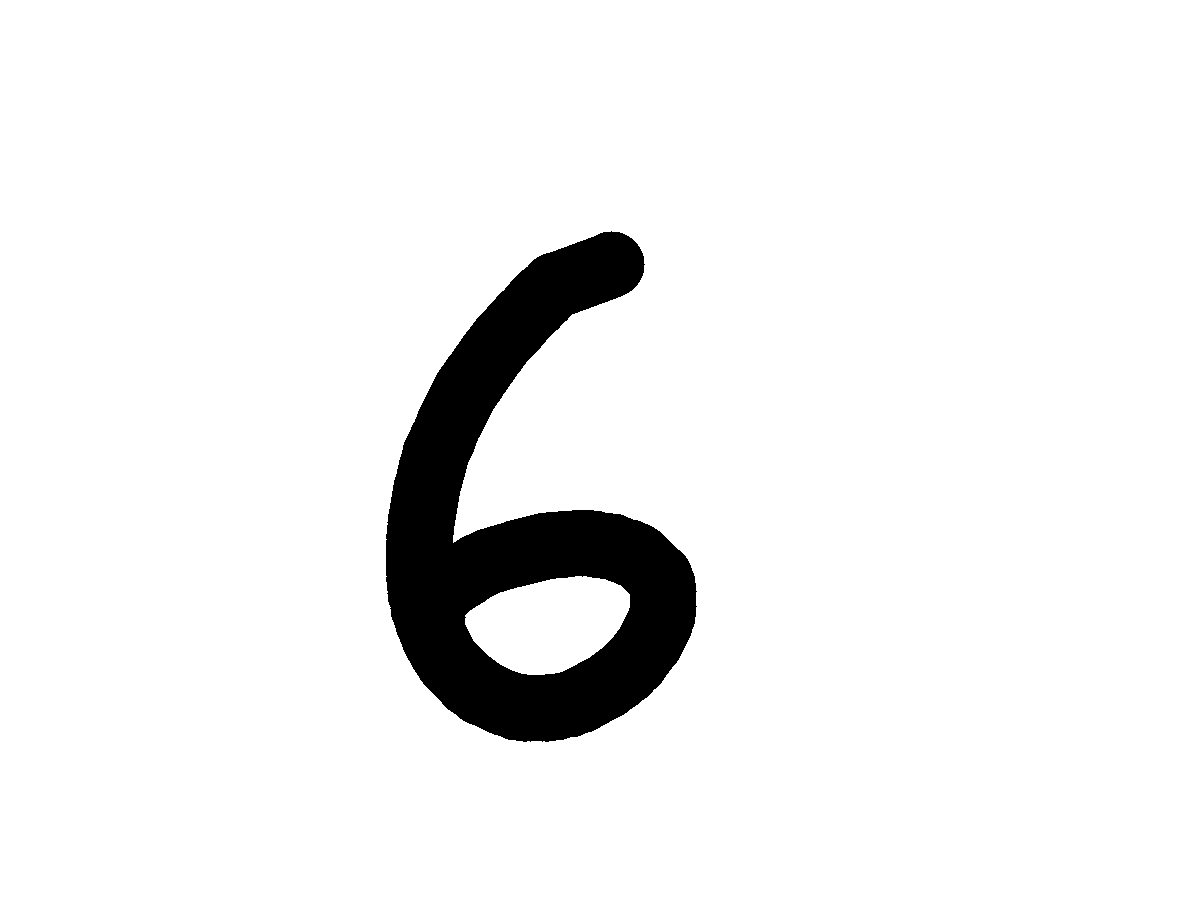

In [752]:
img_dir = 'datasets/handwritten_data/'
temp = X_train.iloc[:, 0].tolist()
temp[5]
img = Image.open(img_dir + temp[335])
img

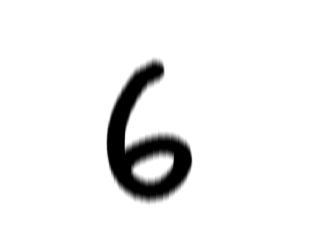

In [753]:
temp = demo_transform(img)
temp

In [754]:
# This is what the actual transformation will be
temp = augment_transform(img)
temp

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Defining the dataset class to read in the datasets and apply transformations as needed

In [755]:
class HandwrittenDataset(Dataset):
    def __init__(self, X, y, img_dir, transform=None, augment=False):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment
        self.augment_transform = augment_transform
        self.classes = '0123456789'
        self.class_to_idx = {c: idx for idx, c in enumerate(self.classes)}
        self.idx_to_class = {idx: c for idx, c in enumerate(self.classes)}
        self.filenames = self.X.iloc[:, 0].astype(str).str.lower().tolist()
        self.labels = self.y.iloc[:, 0].astype(str).tolist()
        
        if self.augment:
            # Duplicate filenames and labels for augment
            self.filenames += self.filenames
            self.labels += self.labels
            

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx % len(self.X)])
        image = Image.open(img_path).convert('RGB')
        
        label_char = str(self.labels[idx % len(self.X)])
        try:
            label = self.class_to_idx[label_char]
        except KeyError:
            raise ValueError(f"Invalid label '{label_char}' found at index {idx}")
        
        # Determine if this is an augmented image
        is_augmented = idx >= len(self.X)
        
        # Apply the appropriate transform
        if is_augmented and self.augment_transform:
            image = self.augment_transform(image)
        elif self.transform:
            image = self.transform(image)
        
        return image, label

In [756]:
# Create augmented training dataset
train_dataset = HandwrittenDataset(
    X_train, y_train, img_dir,
    transform=base_transform,
    augment=True
)

# Test dataset remains unchanged
test_dataset = HandwrittenDataset(
    X_test, y_test, img_dir,
    transform=base_transform,
    augment=False 
)


In [757]:
# DataLoaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Defining the model using PyTorch

In [758]:
# Model Definition
class Handwritten(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(Handwritten, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Output: 32x240x320
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x120x160
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 128x60x80
        self.pool = nn.MaxPool2d(2, 2) # Halves the 2nd and 3rd dimensions
        self.fc1 = nn.Linear(128 * 30 * 40, 512) 
        self.dropout = nn.Dropout(.3)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: 32x120x160
        x = self.pool(F.relu(self.conv2(x)))  # Output: 64x60x80
        x = self.pool(F.relu(self.conv3(x)))  # Output: 128x30x40
        x = x.view(-1, 128 * 30 * 40)         # Flatten to (128 * 30 * 40) = 153600
        x = F.relu(self.fc1(x))               # Output: 512
        x = self.dropout(x)                   # Output: 512
        x = self.fc2(x)                       # Output: 10
        
        return x


Defining device (GPU), compiling model loss and optimizers and running on train set for 10 epochs.

In [759]:
# Device Configuration
device = torch.device("cuda")

# Instantiate Model, Loss Function, and Optimizer
model = Handwritten(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    
    # Set model to training mode
    model.train()
    accuracy = 0
    avg_loss = 0
    running_loss = 0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get predictions and compute accuracy
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability (class prediction)
        total += labels.size(0)  # Total number of labels
        correct += (predicted == labels).sum().item()  # Count correct predictions
        
        running_loss += loss.item()

        # Print loss for every batch
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate and print the average loss and accuracy for the epoch
    avg_loss =  loss.item() / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch [1/10], Step [1/28], Loss: 2.3085
Epoch [1/10], Step [2/28], Loss: 12.3957
Epoch [1/10], Step [3/28], Loss: 5.3281
Epoch [1/10], Step [4/28], Loss: 3.1657
Epoch [1/10], Step [5/28], Loss: 2.6207
Epoch [1/10], Step [6/28], Loss: 2.3417
Epoch [1/10], Step [7/28], Loss: 2.2900
Epoch [1/10], Step [8/28], Loss: 2.3121
Epoch [1/10], Step [9/28], Loss: 2.2960
Epoch [1/10], Step [10/28], Loss: 2.3010
Epoch [1/10], Step [11/28], Loss: 2.2438
Epoch [1/10], Step [12/28], Loss: 2.2211
Epoch [1/10], Step [13/28], Loss: 2.2030
Epoch [1/10], Step [14/28], Loss: 2.2706
Epoch [1/10], Step [15/28], Loss: 2.4167
Epoch [1/10], Step [16/28], Loss: 2.1990
Epoch [1/10], Step [17/28], Loss: 2.0950
Epoch [1/10], Step [18/28], Loss: 1.9627
Epoch [1/10], Step [19/28], Loss: 2.1054
Epoch [1/10], Step [20/28], Loss: 2.1648
Epoch [1/10], Step [21/28], Loss: 2.0071
Epoch [1/10], Step [22/28], Loss: 1.9304
Epoch [1/10], Step [23/28], Loss: 1.7660
Epoch [1/10], Step [24/28], Loss: 1.8787
Epoch [1/10], Step [25/2

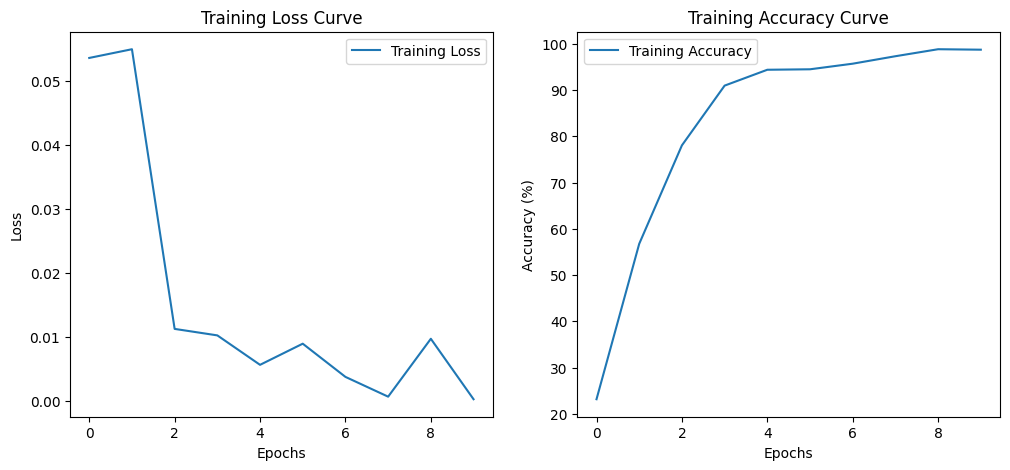

In [760]:
# Plotting the learning curve (Loss & Accuracy)
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()

plt.show()

Evaluating the performance on the test set

In [840]:
# Evaluation on Test Data
model.eval()
correct = 0
total = 0

# Access the idx_to_class mapping from the test dataset
idx_to_class = test_dataset.idx_to_class

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Move tensors to CPU and convert to numpy arrays
        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()
        
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        
        # Iterate over each sample in the batch
        for i in range(len(predicted)):
            pred_idx = predicted[i]
            actual_idx = labels[i]
            pred_char = idx_to_class[pred_idx]
            actual_char = idx_to_class[actual_idx] 
            print(f'Predicted: {pred_char} | Actual: {actual_char}')

print(f'Accuracy on test images: {100 * correct / total:.2f}%')


Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 1 | Actual: 1
Predicted: 8 | Actual: 1
Predicted: 1 | Actual: 1
Predicted: 1 | Actual: 1
Predicted: 1 | Actual: 1
Predicted: 2 | Actual: 2
Predicted: 2 | Actual: 2
Predicted: 2 | Actual: 2
Predicted: 2 | Actual: 2
Predicted: 3 | Actual: 2
Predicted: 3 | Actual: 3
Predicted: 3 | Actual: 3
Predicted: 4 | Actual: 3
Predicted: 3 | Actual: 3
Predicted: 3 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 4 | Actual: 4
Predicted: 4 | Actual: 4
Predicted: 2 | Actual: 4
Predicted: 9 | Actual: 4
Predicted: 5 | Actual: 5
Predicted: 5 | Actual: 5
Predicted: 2 | Actual: 5
Predicted: 5 | Actual: 5
Predicted: 5 | Actual: 5
Predicted: 6 | Actual: 6
Predicted: 6 | Actual: 6
Predicted: 6 | Actual: 6
Predicted: 6 | Actual: 6
Predicted: 6 | Actual: 6
Predicted: 6 | Actual: 6
Predicted: 7 | Actual: 7
Predicted: 7 | Actual: 7
Predicted: 7 | Actual: 7
Predicted: 7 | Actual: 7


Testing model on a single image

In [845]:
def guess_num(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    img = base_transform(image)
    # Make prediction
    img = img.to(device)
    prediction = model(img)
    predicted = prediction.cpu().detach().numpy()
    predicted = np.argmax(predicted)
    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Prediction: {predicted}")
    plt.axis('off')
    plt.show()

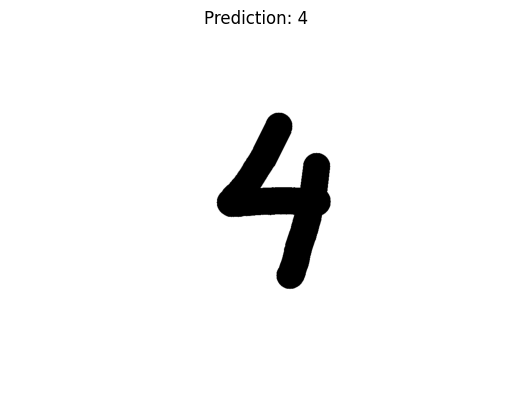

In [846]:
guess_num('four.png')